In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [3]:
#Function of trend differencing and seasonality differencing
def trend_diff(X):
    d = list()
    for i in range(1, len(X)):
        value = X[i] - X[i - 1]
        d.append(value)
    adf_test(d)
    plt.subplot(2,1,1)
    plt.plot(d) 
    plt.show()
    plot_acf(d,lags=30) 
    plt.show()
    return d

def ssn_diff(X, m):
    d = list()
    for i in range(m, len(X)):
        value = X[i] - X[i - m]
        d.append(value)
    adf_test(d)
    plt.subplot(2,1,1)
    plt.plot(d) 
    plt.show()
    plot_acf(d,lags=30) 
    plt.show()
    return d

## 1. INITIAL REVIEW OF THE DATA

In [4]:
series = pd.read_csv('zillow-carlifornia.csv', parse_dates=True,squeeze=True, index_col=0)
#Cleaning column names:
series.columns=['MedianSoldPrice','MedianMortageRate','UnemploymentRate','MedianRentalPrice']

In [5]:
series.head(5)

,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
Date,,,,
2004-01-31,326752.55,5.02,7.9,NaN
2004-02-29,329501.50,4.94,7.8,NaN
2004-03-31,340125.45,4.74,7.8,NaN
2004-04-30,355329.50,5.16,7.5,NaN
2004-05-31,367818.15,5.64,7.3,NaN


/opt/anaconda3/envs/ml/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


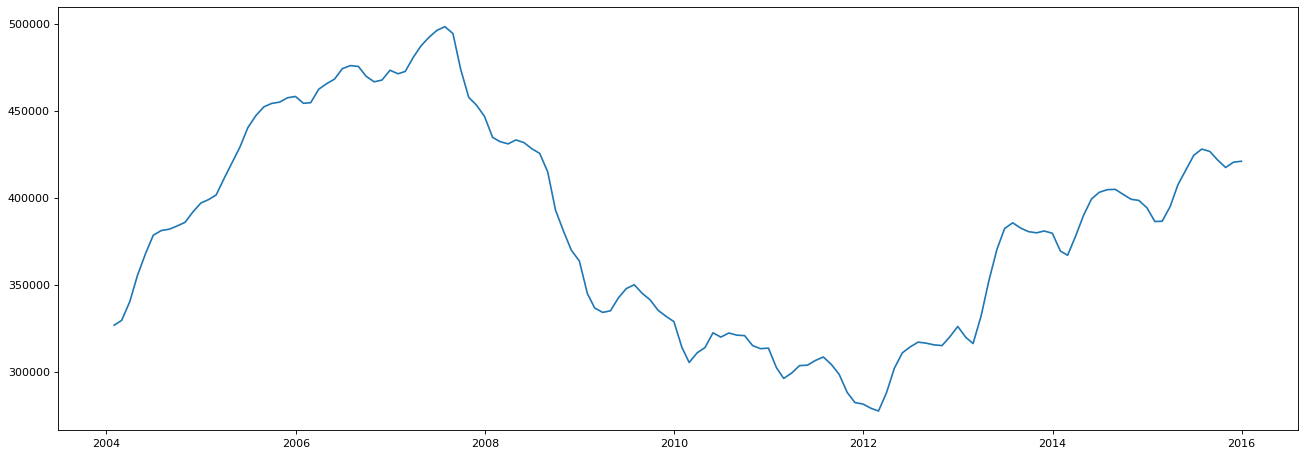

In [6]:
# MedianSoldprice : TARGET
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianSoldPrice'])
plt.show()

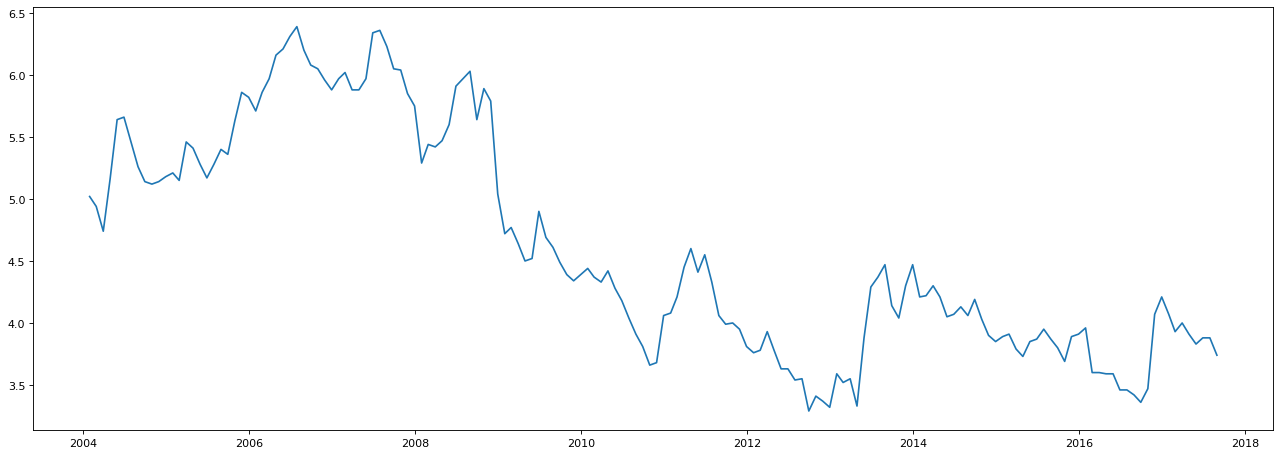

In [7]:
# MedianMortagerate 
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianMortageRate'])
plt.show()

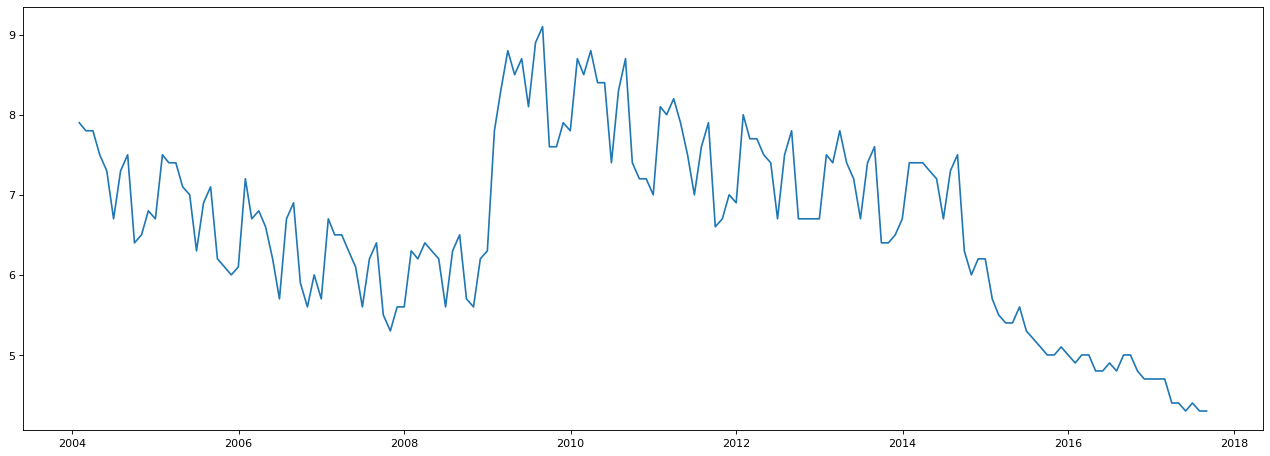

In [8]:
# Unemployment rate
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['UnemploymentRate'])
plt.show()

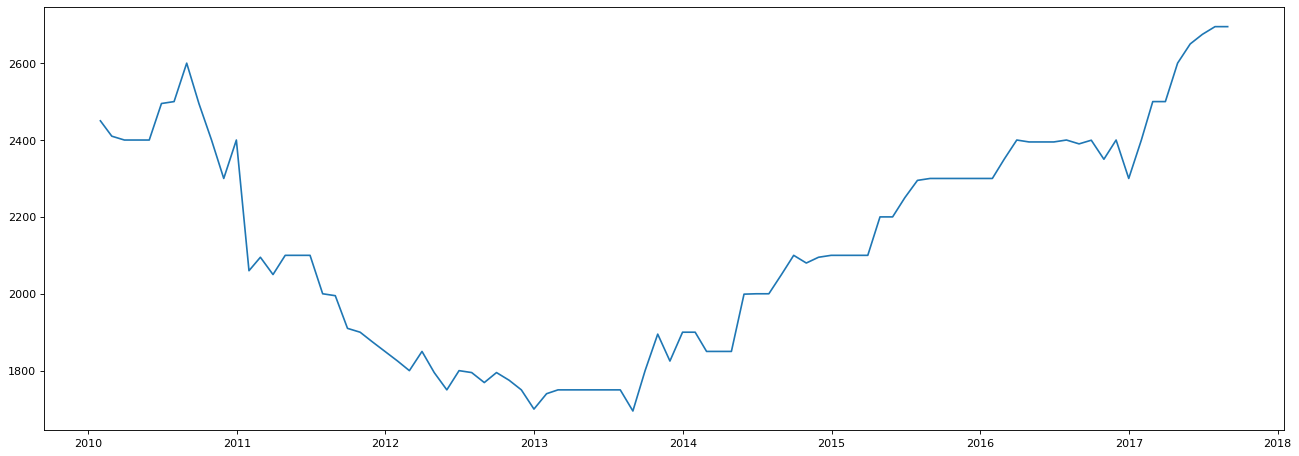

In [9]:
# Rental price
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianRentalPrice'])
plt.show()

In [10]:
#Checking null values in each column
#series.head()
series.isna().sum()

#series.loc[series.MedianSoldPrice.isna()]  #only from 2016-2017 (prediction interval) :ok
#series.loc[series.MedianRentalPrice.isna()] #from 2004-2009

MedianSoldPrice      20
MedianMortageRate     0
UnemploymentRate      0
MedianRentalPrice    72
dtype: int64

,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice
MedianSoldPrice,1.000000,0.051154,-0.709700,0.125483
MedianMortageRate,0.051154,1.000000,0.295279,0.269039
UnemploymentRate,-0.709700,0.295279,1.000000,-0.033633
MedianRentalPrice,0.125483,0.269039,-0.033633,1.000000


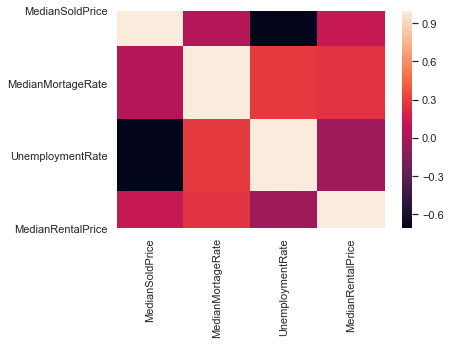

In [11]:
# Correlation matrix for recent years: 2010- 2016
# We see a strong negative relationship between UnemploymentRate - MedianSoldPrice...
import seaborn as sns; sns.set()

series_interval=series.loc[(series.index >= '2010-01-01') & (series.index <='2015-12-31') ]
sns.heatmap(series_interval.corr())
series_interval.corr()

## 2. MODELLING

#### 2.1 SARIMAX Model with only Unemployment over the whole time range


In [12]:
all_price = series[~series.MedianSoldPrice.isna()]['MedianSoldPrice']

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


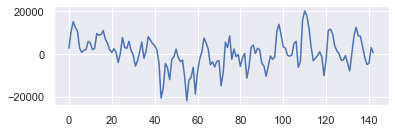

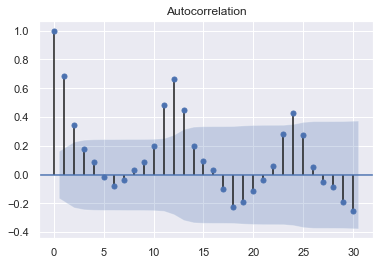

In [13]:
all_price_d1 = trend_diff(all_price)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


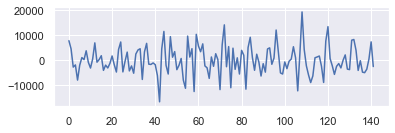

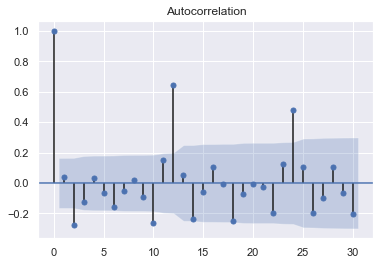

In [14]:
all_price_d2 = trend_diff(all_price_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


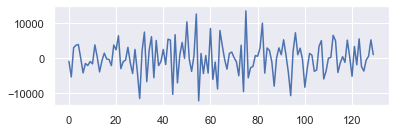

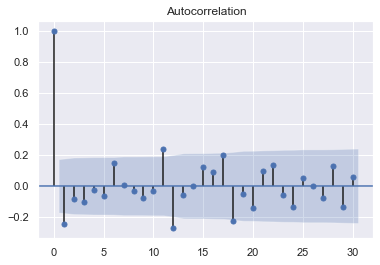

In [15]:
all_price_d3 = ssn_diff(all_price_d2, 12)

In [16]:
train_size_allprice = int(len(all_price) * 0.90)
train_allprice = all_price[:train_size_allprice]
test_allprice = all_price[train_size_allprice:]

In [17]:
model_allprice = pm.auto_arima(train_allprice, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_allprice.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=2271.014, BIC=2284.739, Fit time=0.526 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=2281.524, BIC=2287.014, Fit time=0.019 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=2285.121, BIC=2296.101, Fit time=0.200 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=2285.271, BIC=2296.250, Fit time=0.159 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=2272.973, BIC=2289.443, Fit time=1.117 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2269.067, BIC=2280.047, Fit time=0.132 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2283.388, BIC=2291.623, Fit time=0.060 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2271.067, BIC=2284.792, Fit time=0.387 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=2283.236, BIC=2291.470, Fit time=0.032 seconds
Fit ARIMA: order=(1, 2, 2) s

In [18]:
# Modelling with only UnemploymentRate, all time frame
series_x3=series[['UnemploymentRate']]
exog_train3=series_x3[:train_size_allprice]
exog_test3=series_x3[train_size_allprice:-20]

In [19]:
#SARIMAX(1, 2, 1)x(0, 1, 0, 12)
modelx3 = SARIMAX(train_allprice, order=(1,2,1), seasonal_order=(0,1,0,12),exog=exog_train3)
fitx3=modelx3.fit()
print(fitx3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    MedianSoldPrice   No. Observations:                  129
Model:             SARIMAX(1, 2, 1)x(0, 1, 0, 12)   Log Likelihood               -1132.170
Date:                            Sat, 07 Dec 2019   AIC                           2272.340
Time:                                    19:58:10   BIC                           2283.319
Sample:                                01-31-2004   HQIC                          2276.796
                                     - 09-30-2014                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
UnemploymentRate   370.2004   1035.629      0.357      0.721   -1659.595    2399.996
ar.L1            

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


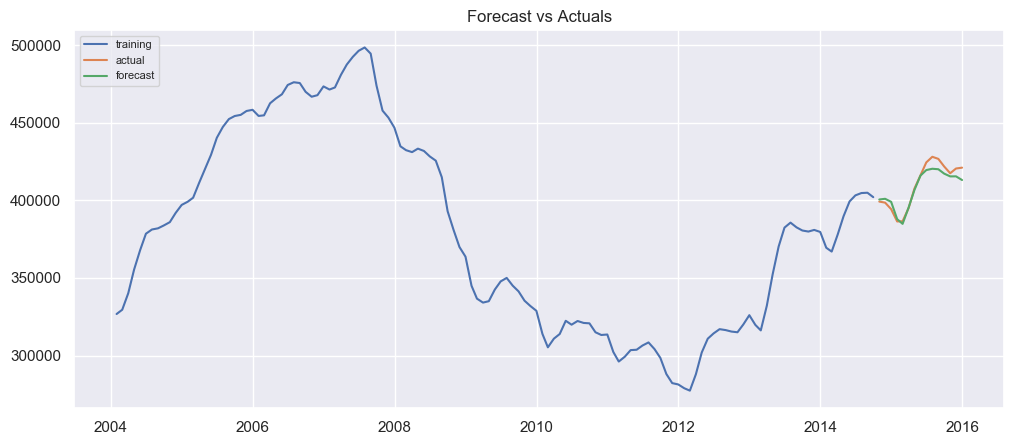

In [20]:
fc = fitx3.predict(start=129, end=143, exog=exog_test3)
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_allprice, label='training')
plt.plot(test_allprice, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
#RMSE is higher than with SARIMA ONLY!!!
rmse = sqrt(mean_squared_error(test_allprice.values, fc_series.values))
rmse

4312.086309866054